In [93]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import display


In [94]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")
df.to_csv("course_lead_scoring.csv", index=False)
df.head()



,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


# Data preparation
Check if the missing values are presented in the features. </br>
If there are missing values:</br>
For caterogiral features, replace them with 'NA'</br>
For numerical features, replace with with 0.0</br>
Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1



In [95]:
df = pd.read_csv("course_lead_scoring.csv")

In [96]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [97]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [98]:
categorical = ['lead_source','industry','employment_status','location']
numerical = ['number_of_courses_viewed','lead_score','annual_income','interaction_count']

In [99]:
df[categorical]=df[categorical].fillna('NA')
df[numerical]=df[numerical].fillna(0.0)

In [100]:
df.isnull().any().sum()

np.int64(0)

In [101]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [102]:
df_full_train=df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train=df_full_train.converted.values
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [103]:
del df_train['converted']
del df_val['converted']
del df_test['converted']
del df_full_train['converted']

# Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.</br>

Let's do that </br>

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth. </br>
Use the training dataset for that</br>
If your AUC is < 0.5, invert this variable by putting "-" in front</br>

(e.g. -df_train['balance'])</br>

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.</br>

Which numerical variable (among the following 4) has the highest AUC?</br>

#### Answer: number_of_courses_viewed



In [53]:
from sklearn.metrics import roc_auc_score

for col in numerical:
    print(col)
    auc_plus = roc_auc_score(y_train, df_train[col])
    auc_neg = roc_auc_score(y_train, -df_train[col])

    print(f"AUC: {max(auc_plus,auc_neg)}")

number_of_courses_viewed
AUC: 0.7635680590007088
lead_score
AUC: 0.6144993577250176
annual_income
AUC: 0.5519578313253012
interaction_count
AUC: 0.738270176293409


# Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters: </br>
</br>
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)</br>
What's the AUC of this model on the validation dataset? (round to 3 digits)</br>

#### Answer  0.72

0.32
0.52
0.72
0.92


In [54]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
converted_decision = (y_pred >= 0.5)
(y_val == converted_decision).mean().round(3)

np.float64(0.7)

# Question 3: Precision and Recall
Now let's compute precision and recall for our model. </br>

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01</br>
For each threshold, compute precision and recall </br>
Plot them </br>
At which threshold precision and recall curves intersect? </br>


#### Answer:  0.545

0.145
0.345
0.545
0.745

In [55]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [56]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores.tail()

,threshold,tp,fp,fn,tn,p,r
96,0.96,3,0,168,122,1.0,0.017544
97,0.97,1,0,170,122,1.0,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000
100,1.00,0,0,171,122,NaN,0.000000


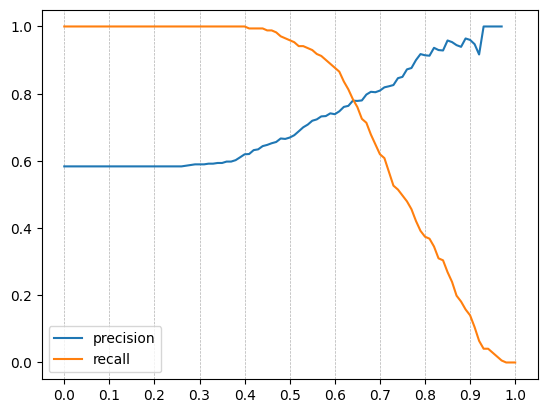

In [57]:
plt.plot(df_scores.threshold, df_scores['p'], label='precision')
plt.plot(df_scores.threshold, df_scores['r'], label='recall')

x_min, x_max = df_scores.threshold.min(), df_scores.threshold.max()
major_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 0.1, 0.1)

plt.xticks(major_ticks)  
plt.grid(axis='x', linestyle='--', linewidth=0.5)  
plt.legend()


In [72]:
df_scores[df_scores['threshold']==0.64]

,threshold,tp,fp,fn,tn,p,r
64,0.64,134,38,37,84,0.77907,0.783626


# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both</br>

This is the formula for computing F1:</br>
</br>
$F 1 = 2⋅ \frac{P⋅R }{P+R}$

Where </br>
P is precision and R is recall.</br>
</br>
Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01</br>
</br>
At which threshold F1 is maximal?</br>

#### Answer:  0.54

0.14</br>
0.34</br>
0.54</br>
0.74 </br>


In [74]:
df_scores['f1'] = 2 * df_scores['p'] * df_scores['r'] / (df_scores['p'] + df_scores['r'])

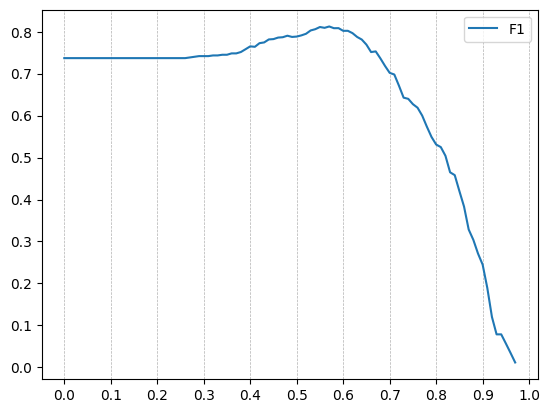

In [79]:
plt.plot(df_scores.threshold, df_scores['f1'], label='F1')
x_min, x_max = df_scores.threshold.min(), df_scores.threshold.max()
major_ticks = np.arange(np.floor(x_min), np.ceil(x_max) + 0.1, 0.1)

plt.xticks(major_ticks)  
plt.grid(axis='x', linestyle='--', linewidth=0.5)  
plt.legend()


In [78]:
best_row = df_scores.loc[df_scores['f1'].idxmax()]
best_threshold = best_row['threshold']
best_f1 = best_row['f1']

print("Best Threshold:", best_threshold)
print("Best F1-Score:", best_f1)

Best Threshold: 0.5700000000000001
Best F1-Score: 0.8124999999999999


# Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds: </br>

KFold(n_splits=5, shuffle=True, random_state=1) </br>
Iterate over different folds of df_full_train </br>
Split the data into train and validation </br>
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) </br>
Use AUC to evaluate the model on validation </br>
How large is standard deviation of the scores across different folds? </br>

#### Answer:  0.06
0.0001 </br>
0.006 </br>
0.06 </br>
0.36 </br>


In [105]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [106]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [111]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = y_full_train[train_idx]
    y_val = y_full_train[val_idx]

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
scores

[0.8060745924216483,
 0.8713738368910783,
 0.7754320118852139,
 0.8018368617683685,
 0.8558272713202291]

In [112]:
std_dev = np.std(scores)
round(std_dev,4)

np.float64(0.0358)

# Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C </br>
</br>
Iterate over the following C values: [0.000001, 0.001, 1] </br>
Initialize KFold with the same parameters as previously </br>
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000) </br>
Compute the mean score as well as the std (round the mean and std to 3 decimal digits) </br>
Which C leads to the best mean score? </br>

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.</br>

#### Answer: 0.001


In [118]:
from tqdm.auto import tqdm

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = y_full_train[train_idx]
        y_val = y_full_train[val_idx]
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024
C=0.001 0.867 +- 0.029
C=1 0.822 +- 0.036
